In [58]:
from fastai.data.block import DataBlock, MultiCategoryBlock, CategoryBlock
from fastai.vision.data import ImageBlock, get_image_files, parent_label
from fastai.vision.learner import vision_learner, Learner
from fastai.vision.all import resnet34, ClassificationInterpretation
from fastai.data.transforms import RandomSplitter
from fastai.metrics import accuracy, Precision
from torch import topk, zeros
import matplotlib.pyplot as plt


In [59]:
def label_func(x):
    label = parent_label(x)
    return [label[0],label[1]]

def gender_label(x):
    return label_func(x)[0]

def adhd_label(x):
    return label_func(x)[1]

In [60]:
gender_data = DataBlock(blocks=(ImageBlock, CategoryBlock),
    splitter=RandomSplitter(),
    get_y=gender_label
)

adhd_data = DataBlock(blocks=(ImageBlock, CategoryBlock),
    splitter=RandomSplitter(),
    get_y=adhd_label
)

In [61]:
files = get_image_files("data/generated")

In [62]:
files_czf4 = list(filter(lambda f: str(f).endswith('CzF4.png'), files))
files_01f4 = list(filter(lambda f: str(f).endswith('01F4.png'), files))
files_f3f4 = list(filter(lambda f: str(f).endswith('F3F4.png'), files))
files_fzf4 = list(filter(lambda f: str(f).endswith('FzF4.png'), files))

In [63]:
dls_sets = {
    'czf4': (gender_data.dataloaders(files_czf4), adhd_data.dataloaders(files_czf4)),
    '01f4': (gender_data.dataloaders(files_01f4), adhd_data.dataloaders(files_01f4)),
    'f3f4': (gender_data.dataloaders(files_f3f4), adhd_data.dataloaders(files_f3f4)),
    'fzf4': (gender_data.dataloaders(files_fzf4), adhd_data.dataloaders(files_fzf4)),
}

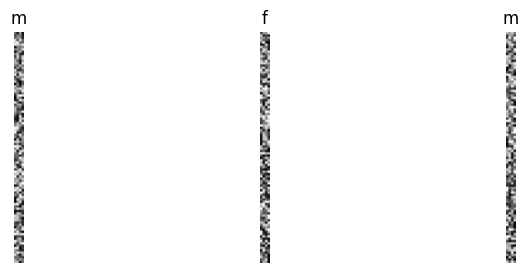

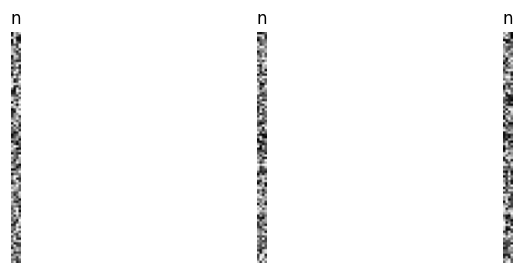

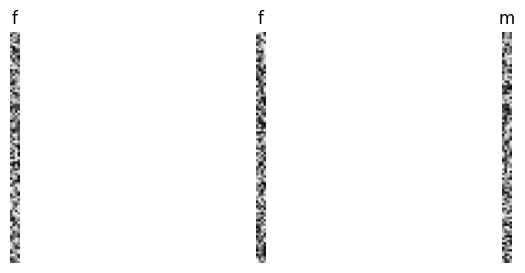

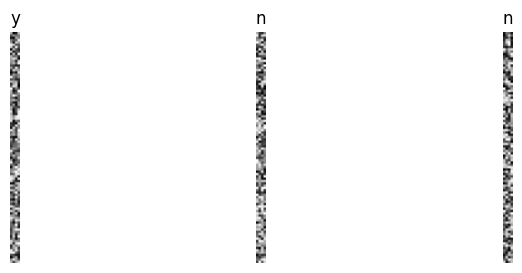

In [64]:
dls_sets['czf4'][0].show_batch(max_n = 3)
dls_sets['czf4'][1].show_batch(max_n = 3)
dls_sets['f3f4'][0].show_batch(max_n = 3)
dls_sets['f3f4'][1].show_batch(max_n = 3)

In [65]:
learners: dict[str, tuple[Learner, Learner]] = {}

for k, v in dls_sets.items():
    p_precision = Precision(pos_label=0)
    n_precision = Precision(pos_label=1)
    gender_learn = vision_learner(v[0], resnet34, metrics=[accuracy, p_precision, n_precision])
    adhd_learn = vision_learner(v[1], resnet34, metrics=[accuracy, p_precision, n_precision])

    learners[k] = (gender_learn, adhd_learn)

In [66]:
cycles = 10
for k, v in learners.items():
    print("training", k)
    print("gender")
    v[0].fine_tune(cycles)
    print("adhd")
    v[1].fine_tune(cycles)

training czf4
gender


epoch,train_loss,valid_loss,accuracy,precision_score,precision_score,time
0,0.685283,0.639014,0.684598,0.381579,0.715734,03:20


epoch,train_loss,valid_loss,accuracy,precision_score,precision_score,time
0,0.621495,0.600470,0.716015,0.668508,0.717371,04:51
1,0.610787,0.605029,0.719540,0.920000,0.716420,04:47
2,0.600264,0.604348,0.718621,0.861111,0.716223,04:44
3,0.570179,0.618501,0.703142,0.460751,0.714538,04:45
4,0.410500,0.801907,0.635096,0.315706,0.712058,04:42
5,0.217782,1.105223,0.646743,0.328659,0.714153,04:44
6,0.091557,1.500018,0.633257,0.328561,0.716264,04:46
7,0.055013,1.789899,0.636475,0.318542,0.712711,04:49
8,0.027500,1.875353,0.643218,0.328926,0.714770,04:51
9,0.025055,1.907010,0.631418,0.318551,0.713264,05:05


adhd


epoch,train_loss,valid_loss,accuracy,precision_score,precision_score,time
0,0.764562,0.793481,0.518774,0.549932,0.454885,03:18


epoch,train_loss,valid_loss,accuracy,precision_score,precision_score,time
0,0.698648,0.690532,0.540690,0.556049,0.481371,04:56
1,0.701826,0.692245,0.521533,0.556548,0.464902,04:56
2,0.694870,0.710665,0.532874,0.551798,0.464159,04:52
3,0.651143,0.711030,0.522759,0.556946,0.465932,04:49
4,0.472467,0.945209,0.507586,0.554203,0.457885,05:05
5,0.235407,1.458896,0.507586,0.550878,0.454731,04:49
6,0.126954,1.671541,0.510805,0.551577,0.455983,04:49
7,0.058681,2.122076,0.515862,0.554317,0.460270,04:48
8,0.032869,2.301404,0.504521,0.551724,0.455172,04:53
9,0.025490,2.332734,0.507280,0.548777,0.452211,04:52


training 01f4
gender


epoch,train_loss,valid_loss,accuracy,precision_score,precision_score,time
0,0.874237,0.695512,0.665617,0.336088,0.713542,01:25


epoch,train_loss,valid_loss,accuracy,precision_score,precision_score,time
0,0.669138,0.621562,0.708989,0.521739,0.716837,02:04
1,0.632875,0.615241,0.715285,0.649351,0.717110,02:04
2,0.591891,0.677694,0.712487,0.580645,0.716920,02:04
3,0.527505,0.709659,0.686254,0.395833,0.718786,02:05
4,0.319822,0.938886,0.628891,0.321656,0.715374,02:04
5,0.174475,1.254192,0.639734,0.308911,0.710705,02:05
6,0.082029,1.569996,0.628891,0.306897,0.710838,02:06
7,0.046930,1.661519,0.657922,0.337931,0.715347,02:05
8,0.022469,1.745274,0.648129,0.320594,0.712730,02:06
9,0.017622,1.751937,0.625394,0.315457,0.713708,02:05


adhd


epoch,train_loss,valid_loss,accuracy,precision_score,precision_score,time
0,0.995253,0.792161,0.494229,0.534236,0.462882,01:27


epoch,train_loss,valid_loss,accuracy,precision_score,precision_score,time
0,0.752562,0.710614,0.508220,0.534807,0.462345,02:06
1,0.705754,0.695961,0.534103,0.544326,0.495854,02:04
2,0.691789,0.707490,0.527457,0.543447,0.484536,02:06
3,0.621112,0.771373,0.495628,0.530571,0.458544,02:04
4,0.396796,1.057837,0.520112,0.548251,0.481266,02:04
5,0.184738,1.424677,0.529556,0.561151,0.493233,02:04
6,0.091253,1.801607,0.515915,0.547074,0.477855,02:03
7,0.048153,2.053011,0.512067,0.545155,0.474665,02:04
8,0.032713,2.080777,0.517664,0.548695,0.479814,02:05
9,0.022184,2.094747,0.513816,0.542112,0.473146,02:04


training f3f4
gender


epoch,train_loss,valid_loss,accuracy,precision_score,precision_score,time
0,1.049684,0.770332,0.646288,0.314199,0.719520,00:54


epoch,train_loss,valid_loss,accuracy,precision_score,precision_score,time
0,0.744727,0.646387,0.705786,0.420455,0.720183,01:19
1,0.680756,0.647295,0.718341,0.546392,0.727954,01:19
2,0.634218,0.643284,0.711790,0.480000,0.721685,01:19
3,0.545934,0.749503,0.667576,0.367925,0.730515,01:24
4,0.372521,0.916193,0.643559,0.354545,0.734914,01:20
5,0.193377,1.166392,0.645196,0.350835,0.732484,01:19
6,0.092118,1.445947,0.631004,0.316302,0.722027,01:19
7,0.047087,1.563640,0.632642,0.317734,0.722300,01:19
8,0.024825,1.601221,0.637009,0.320513,0.722607,01:20
9,0.020419,1.612838,0.644651,0.323034,0.722222,01:18


adhd


epoch,train_loss,valid_loss,accuracy,precision_score,precision_score,time
0,1.201533,0.984462,0.487445,0.513490,0.443631,00:52


epoch,train_loss,valid_loss,accuracy,precision_score,precision_score,time
0,0.838768,0.822603,0.500546,0.522597,0.456911,01:19
1,0.766665,0.767524,0.525109,0.538880,0.492674,01:18
2,0.721728,0.790112,0.522926,0.537094,0.488848,01:19
3,0.614674,0.834627,0.528930,0.548242,0.499308,01:19
4,0.380309,1.205743,0.514192,0.539604,0.482968,01:19
5,0.220741,1.513545,0.530022,0.553801,0.500611,01:19
6,0.101959,1.916390,0.529476,0.555670,0.500000,01:19
7,0.056636,1.963078,0.522380,0.546983,0.492083,01:32
8,0.030953,2.000864,0.522926,0.546243,0.492443,01:49
9,0.023502,1.984218,0.526201,0.547753,0.496073,01:22


training fzf4
gender


epoch,train_loss,valid_loss,accuracy,precision_score,precision_score,time
0,1.059772,0.821021,0.639738,0.330159,0.704021,00:55


epoch,train_loss,valid_loss,accuracy,precision_score,precision_score,time
0,0.752784,0.671960,0.687773,0.427481,0.707819,01:20
1,0.676829,0.689130,0.687227,0.424242,0.707647,01:20
2,0.620179,0.691181,0.657205,0.334802,0.702804,01:31
3,0.515890,0.744867,0.669760,0.405109,0.716303,01:23
4,0.345522,1.026356,0.621179,0.301408,0.698037,01:20
5,0.178404,1.284952,0.633734,0.329480,0.704576,01:19
6,0.079089,1.492259,0.627183,0.330729,0.705801,01:22
7,0.044179,1.619835,0.649017,0.350993,0.707843,01:21
8,0.034047,1.660866,0.648472,0.348837,0.707381,01:22
9,0.018428,1.615655,0.640830,0.351275,0.709939,01:21


adhd


epoch,train_loss,valid_loss,accuracy,precision_score,precision_score,time
0,1.122521,0.826545,0.515284,0.579276,0.465567,00:53


epoch,train_loss,valid_loss,accuracy,precision_score,precision_score,time
0,0.812983,0.721559,0.527293,0.566459,0.465541,01:21
1,0.746951,0.709101,0.522926,0.566572,0.463131,01:20
2,0.701964,0.712524,0.540939,0.583015,0.484694,01:20
3,0.582512,0.833905,0.497817,0.560051,0.450528,01:20
4,0.356122,1.195240,0.503821,0.565920,0.455253,01:20
5,0.179275,1.511025,0.526201,0.577125,0.470990,01:20
6,0.081836,1.743526,0.541485,0.591241,0.486827,01:22
7,0.044142,1.822871,0.544760,0.591138,0.489869,01:21
8,0.021163,1.972638,0.546943,0.604520,0.493136,01:21
9,0.021607,1.957360,0.544214,0.588933,0.489024,01:20


In [67]:
interpretations: dict[str, ClassificationInterpretation] = {}
for k, v in learners.items():
    interpretations[f'{k}_gender'] = ClassificationInterpretation.from_learner(v[0])
    interpretations[f'{k}_adhd'] = ClassificationInterpretation.from_learner(v[1])

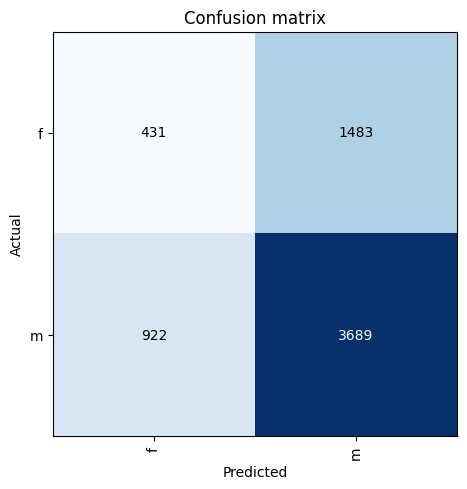

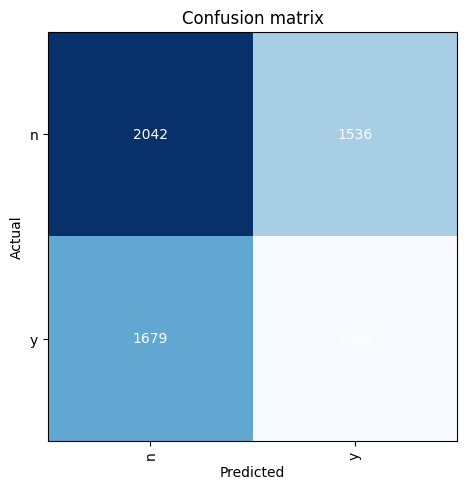

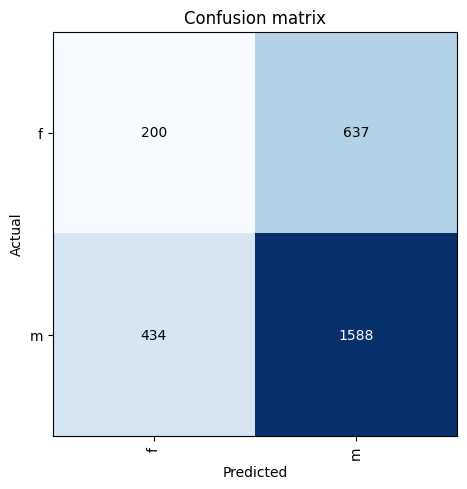

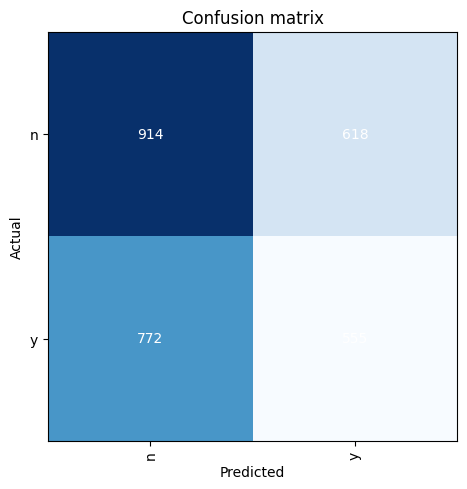

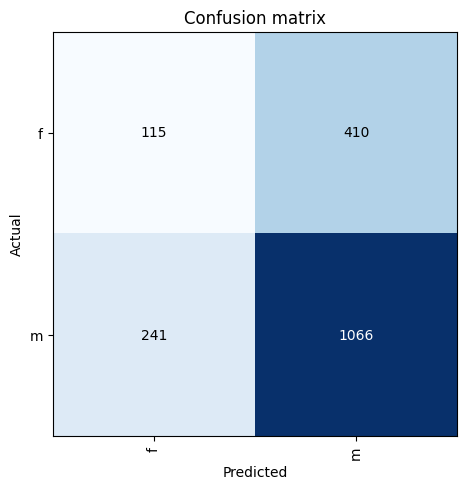

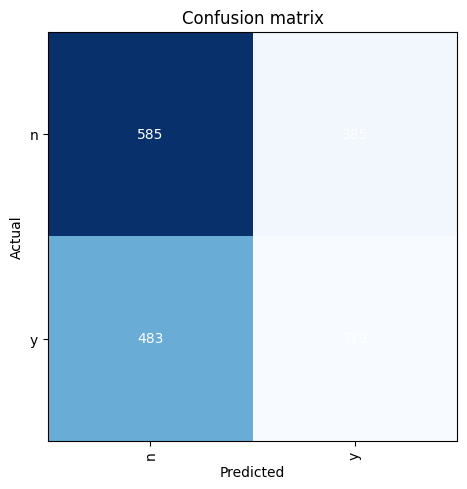

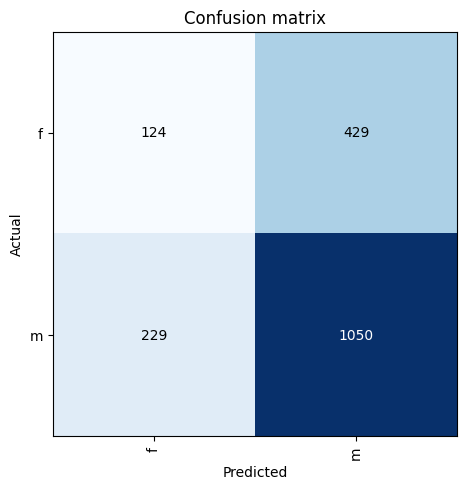

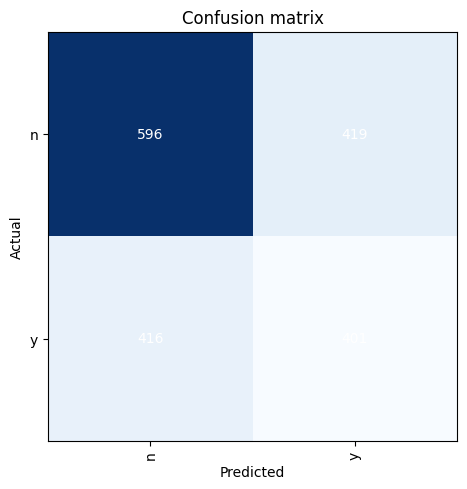

In [68]:
for i in interpretations.values():
    i.plot_confusion_matrix()